In [1]:
# David Caratelli @ FNAL [davidc@fnal.gov]
# 02/04/2018

In [2]:
%matplotlib inline
#%pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
import matplotlib.dates as dts
import numpy as np
import pandas as pd
import itertools
import os
import ROOT
import datetime
from root_numpy import root2array, root2rec, tree2rec, array2root
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.misc import factorial
plt.rcParams.update({'font.size': 18})

Welcome to JupyROOT 6.10/04


In [3]:
# Argon properties

#LAr temperature
T = 89
# density
rho = 1.38 # g/cm^3

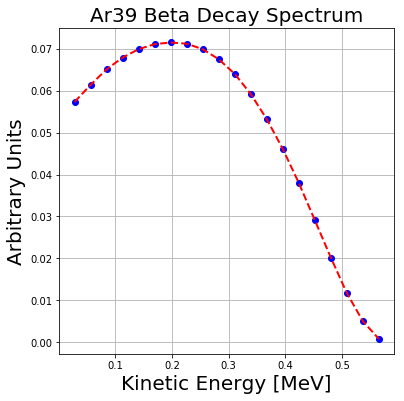

In [4]:
# Ar 39 energy spectrum

Ar39_E_v = [0.0282,0.0565,0.0847,0.1130,0.1412,0.1695,0.1977,0.2260,\
            0.2542,0.2825,0.3107,0.3390,0.3672,0.3955,0.4237,0.4520,0.4802,0.5085,0.5367,0.5650]

Ar39_A_v = [5.73E-02,6.14E-02,6.51E-02,6.79E-02,6.99E-02,7.11E-02,7.15E-02,\
            7.12E-02,6.99E-02,6.75E-02,6.40E-02,5.92E-02,5.32E-02,4.61E-02,\
            3.80E-02,2.91E-02,2.02E-02,1.17E-02,5.02E-03,7.77E-04]

# spline
Ar39spectrum = interp1d(Ar39_E_v,Ar39_A_v)

fig = plt.figure(figsize=(6,6))
plt.plot(Ar39_E_v,Ar39_A_v,'bo',lw=2)
xvals = np.linspace(Ar39_E_v[0],Ar39_E_v[-1],100)
plt.plot(xvals,Ar39spectrum(xvals),'r--',lw=2)
plt.xlabel("Kinetic Energy [MeV]",fontsize=20)
plt.ylabel('Arbitrary Units',fontsize=20)
plt.title('Ar39 Beta Decay Spectrum',fontsize=20)
plt.grid()
plt.show()


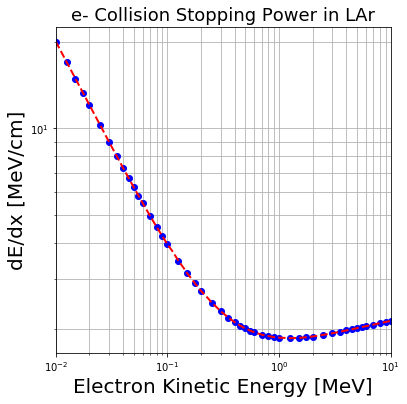

In [5]:
# load electron energy loss info [NIST]
fin = open('nist_esar_ar_1p38density_188eV.txt','r')
ctr = 0

energy_v = []
collision_v = []

for line in fin:
    ctr += 1
    
    if (ctr < 9):
        continue
    words = line.split()
    if (len(words) != 4):
        continue
    energy_v.append   ( float(words[0])       )
    collision_v.append( float(words[1]) * rho )
    
energy_v    = np.array(energy_v   )
collision_v = np.array(collision_v)

dEdx = interp1d(energy_v,collision_v)

fig = plt.figure(figsize=(6,6))
plt.plot(energy_v,collision_v,'bo',lw=2)
xvals = np.linspace(0.01,10,1000)
plt.plot(xvals,dEdx(xvals),'r--',lw=2)
plt.xlim([0.01,10])
plt.xscale('log')
plt.yscale('log')
plt.grid(which='both')
plt.xlabel('Electron Kinetic Energy [MeV]',fontsize=20)
plt.ylabel('dE/dx [MeV/cm]',fontsize=20)
plt.title('e- Collision Stopping Power in LAr',fontsize=18)
plt.show()

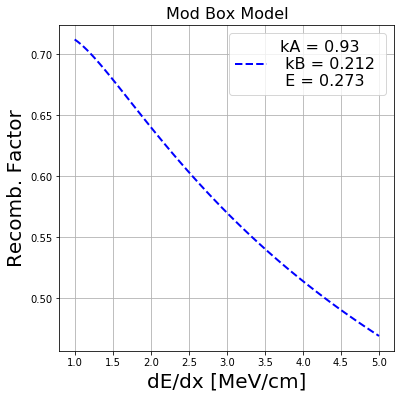

In [6]:
# Ion recombination model

# recombination model
def RecombModBox(dEdx, A, B, Efield):
    B /= (rho * Efield)
    r = np.log( dEdx * B + A ) / ( dEdx * B )
    return 1-r

def RecombBirks(dEdx, A, k, Efield):
    k /= rho
    r = ( 1 + k * dEdx / Efield ) / A
    return 1/r


fRecombA  = 0.8 # +- 0.003
fRecombk  = 0.0486 # +- 0.0006

fModBoxA = 0.93
fModBoxB = 0.212#0.212#3

fEfield  = 0.273

fig = plt.figure(figsize=(6,6))
dedx_v = np.linspace(1,5,100)
R_v = []
for dedx in dedx_v:
    R_v.append(1-RecombModBox(dedx,fModBoxA,fModBoxB,fEfield))
plt.plot(dedx_v,R_v,'b--',lw=2,label='kA = 0.93 \n kB = 0.212 \n E = 0.273')
plt.grid()
plt.xlabel('dE/dx [MeV/cm]',fontsize=20)
plt.ylabel('Recomb. Factor',fontsize=20)
plt.title('Mod Box Model',fontsize=16)
plt.legend(loc=1,fontsize=16)
plt.show()

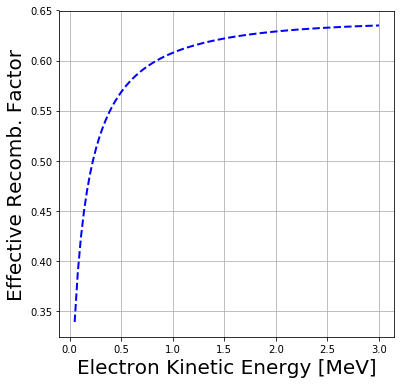

In [34]:
# Apply recombination model to get effective recombination for each electron energy
# return effective charge quenching amount
# effective recombination = amount of recombination for total energy lost by electron of given KE.

def EffectiveRecomb(ElectronEnergy,Estep,Field):
    
    # keep track of total energy lost
    dEtot = 0.
    # and total energy "seen" after recomb.
    dEobs = 0.
    
    while (ElectronEnergy > 1e-2):
    
        dedx = dEdx(ElectronEnergy)
        R    = RecombModBox(dedx,fModBoxA,fModBoxB,Field)
        
        dEtot += Estep
        dEobs += Estep * (1-R)
        
        ElectronEnergy -= Estep
        
        #print '@ E = %.02f : dE/dx : %.02f Etot : %.02f Eobs : %.02f'%(ElectronEnergy,dedx,dEtot,dEobs)
        
    # perform last step
    dedx = dEdx(1e-2)
    dEtot += ElectronEnergy
    dEobs += ElectronEnergy * (1 - RecombModBox(dedx,fModBoxA,fModBoxB,Field))
    #print '@ E = %.02f : dE/dx : %.02f Etot : %.02f Eobs : %.02f'%(ElectronEnergy,dedx,dEtot,dEobs)
    
    return dEobs/dEtot


def Charge(ElectronEnergy,efield):
    
    EffRecomb = EffectiveRecomb(ElectronEnergy,0.01,efield)
    Eobs = ElectronEnergy * EffRecomb
    Qobs = Eobs / (23.6 * (1e-6))
    return Qobs

EffectiveRecomb_v = np.vectorize(EffectiveRecomb)
Charge_v = np.vectorize(Charge)

EffectiveRecomb(0.25,0.01,0.273)

fig = plt.figure(figsize=(6,6))
Evals = np.linspace(0.05,3,100)
Rvals = []
for E in Evals:
    Rvals.append(EffectiveRecomb(E,0.01,0.273))
plt.plot(Evals,Rvals,'b--',lw=2)
plt.xlabel('Electron Kinetic Energy [MeV]',fontsize=20)
plt.ylabel('Effective Recomb. Factor',fontsize=20)
plt.grid()
plt.show()

In [56]:
# calculate Ar39 spectrum [in drifted electrons] accounting for recombination

# sample randomly from Ar39 spectrum and calculate visible charge for each event
Ar39_Q_v = []

Eavg = 0.

for n in xrange(5000):
    
    found = False
    while (found == False):
        Eval = np.random.uniform(Ar39_E_v[0],Ar39_E_v[-1])
        if (Ar39spectrum(Eval) > np.random.uniform(0,0.08) ): # 0.08 due to values in 1st histogram in notebook
            found = True
    Eavg += Eval
    EffRecomb = EffectiveRecomb(Eval,0.01,0.273)
    Eobs = Eval * EffRecomb
    Qobs = Eobs / (23.6 * (1e-6))
    Ar39_Q_v.append(Qobs)
Eavg /= 5000
print Eavg

0.242441134502


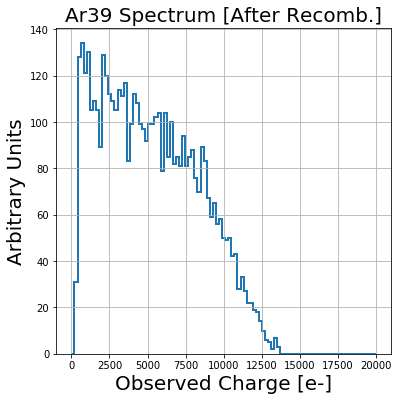

In [30]:
fig = plt.figure(figsize=(6,6))
plt.hist(Ar39_Q_v,bins=np.linspace(0,2e4,100),histtype='step',lw=2)
plt.grid()
plt.xlabel('Observed Charge [e-]',fontsize=20)
plt.ylabel('Arbitrary Units',fontsize=20)
plt.title('Ar39 Spectrum [After Recomb.]',fontsize=20)
plt.show()

In [51]:
elec_KE = np.linspace(0.05,1,100)
elec_Q_273 = []
elec_Q_500 = []
for ke in elec_KE:
    elec_Q_273.append(Charge(ke,0.273)/1e3)
    elec_Q_500.append(Charge(ke,0.500)/1e3)

In [52]:
plt.rcParams.update({'font.size': 18})

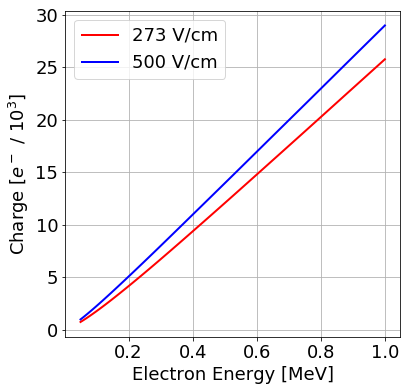

In [53]:
fig = plt.figure(figsize=(6,6))
plt.plot(elec_KE,elec_Q_273,lw=2,color='r',label='273 V/cm')
plt.plot(elec_KE,elec_Q_500,lw=2,color='b',label='500 V/cm')
plt.grid()
plt.xlabel('Electron Energy [MeV]')
plt.ylabel('Charge [$e^-$ / $10^3$]')
plt.legend(loc=2,fontsize=18)
plt.show()

In [55]:
print Charge(0.2,0.273)

4129.221044959042
